# Cohort & Survival Analysis

<img src="pic/cohort_matrix.png" width=600>

## What is a Cohort?

In wikipedia, the definition of cohort is as follows:

> In statistics, marketing and demography, a cohort is **a group of subjects who share a defining characteristic** (typically **subjects who experienced a common event in a selected time period**, such as birth or graduation).

In business, **a cohort is simply a subset of users grouped by shared characteristics.** For example, they might have their first purchase in the given amount of time. They might also be the people who enjoys the same anniversary sales event in the department store. We can observe how a cohort behaves across time and compare it to other cohorts. Cohorts are used in medicine, psychology, econometrics, ecology and many other areas to perform a cross-section (compare difference across subjects) analysis at intervals through time.

---
## Why Cohort Analysis is important?

Running a cohort analysis is probably one of the simplest ways to do A/B testing for your business. For example, you can raise a time-bound experiment with the characteristics you want to test, say new landing page design. You can then compare the metrics two different cohorts. Since the experiment is time-bound, you can compare the metrics across two different cohorts to see whether the new landing page can acquire more customer. 

This is the real value and purpose of marketing analytics in the first place. Simply put, marketing analytics tells you what is working, what is not working, and how to adjust your marketing activities based on this feedback. Cohort analysis does just that by focusing on the effect of each marketing activity or change on a specific audience in time. **Cohort Analysis is also an extremely important analysis for ecommerce and web- or app- based application**, where user engagements are recorded.

In the following notebook we will use the [Online retail dataset from UCI](https://www.kaggle.com/jihyeseo/online-retail-data-set-from-uci-ml-repo) to implement cohort analysis and see what we can get from it.

---
## Notebook Setting

In [49]:
import numpy as np
import pandas as pd
import datetime as dt
import os

#For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For Machine Learning Algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [50]:
def load_data(filepath):
    """
    Load data and perform necessary operation.
    
    Parameters
    ---------
    filepath: filepath of the name
    """
    df = pd.read_csv('online_retail.csv')
    
    # Parse datetime objects
    df.InvoiceDate = df.InvoiceDate.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    
    # Create a TotalPrice Columns
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    
    # Drop null customer to make this data cleaner.
    df = df.dropna(subset=['CustomerID'])
    
    # Query data with the transaction data
    df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
    
    return df

In [51]:
df = load_data('online_retail.csv')

In [52]:
df.describe()

,Quantity,UnitPrice,CustomerID,TotalPrice
count,397884.000000,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453,22.397000
std,179.331775,22.097877,1713.141560,309.071041
min,1.000000,0.001000,12346.000000,0.001000
25%,2.000000,1.250000,13969.000000,4.680000
50%,6.000000,1.950000,15159.000000,11.800000
75%,12.000000,3.750000,16795.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


---
## Types of Cohorts

There are different definitions of a cohort. Some of the most widely know ones are:

1. **Time Cohorts**: Time Cohorts are **customers who signed up for a product or service during a certain period of time**. Analyzing these cohorts shows the customers’ behavior depending on the time they started using the company’s products or services. The time may be monthly or quarterly even daily. 


2. **Behavior Cohorts**: Behaovior cohorts are **customers who purchased a product or subscribed to a service in the past**. It groups customers **by the type of product or service they signed up**. Customers who signed up for basic level services might have different needs than those who signed up for advanced services. Understaning the needs of the various cohorts can help a company design custom-made services or products for particular segments.


3. **Size cohorts**: Size cohorts refer to **the various sizes of customers who purchase company’s products or services**. This categorization can be based on **the amount of spending in some periodic time after acquisition** or **the product type that the customer spent most of their order amount** in some period of time.

In the context of business analytics, a cohort usually refers to a subset of users specifically segmented by acquisition date (i.e. the first time a user visits your website). Analyzing in the context of cohort instead of a single person helps understand how a particular group of customers develops over its lifecycle. Some questions are like:

* Is there a high churn? (This will be indicated by a low number of follow-up bookings/purchases.)
* Do customers become more engaged over time? (This may be demonstrated by the fact that the longer the stay with the company, the more booking/purhcasing they make.)

---
## Generate Cohort


In this notebook, we will try to build a time-based cohort anlaysis via Python. Before we first dive into the detail, we need to create some extra information for this dataset.

What should we know about this data in order to do time-based cohorts analysis? 

1. We need to re-organize our dataset so that each row (observation) is basically one order. This can be done by grouping the InvoiceNo.

2. We definitely should understand whether or not the purchase is a repeated order or the first purchase. We will group those purchases with the same "first purchase period" together. The customers that made these grouped purchases are considered the same cohort.

In [63]:
def _generate_time_intervals(invoice_time, interval):
    """
    Generate time intervals
    
    Parameters
    --------
    invoice_time: 
    interval: quarter or month
    """
    res = []
    for time in invoice_time:
        year = time.year
        if interval == 'Quarter':
            timeval = (time.month + 2) //3
            res.append(dt.datetime(year, timeval*3-2, 1))
        else:
            timeval = time.month
            res.append(dt.datetime(year, timeval, 1))
    return(res)

def _get_cohort_index(df, interval):
    """
    Generate cohort.
    
    Parameters
    --------
    df: dataset 
    interval: quarter or month as interval
    """
    cohort_ind = []
    iterables = zip(df['InvoiceMonth'], df['CohortMonth']) if interval == 'Month' else zip(df['InvoiceQuarter'], df['CohortQuarter'])
    
    for invoice, cohort in iterables:
        year_diff = invoice.year - cohort.year 
        month_diff = invoice.month - cohort.month 
        cohort_ind.append(year_diff * 12 + month_diff + 1 )
    return(cohort_ind)

def generate_time_cohort_analysis(df, interval):
    """
    Create cohort analysis. 
    
    Parameters
    --------
    df: dataset 
    interval: quarter or month as interval
    """
    data = df.copy()
    
    try:
        data[f'Invoice{interval}'] = _generate_time_intervals(df.InvoiceDate, interval)
        data[f'Cohort{interval}'] = data.groupby('CustomerID')[f'Invoice{interval}'].transform(min)
        data['CohortIndex'] = _get_cohort_index(data, interval)
    except:
        raise NotImplementedError(f'Interval: "{interval}" is not implemented. Please input valid time interval. Quarter or Month.')

    cohort_data = data.groupby([f'Cohort{interval}','CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
    cohort_counts = cohort_data.pivot(index=f'Cohort{interval}',columns='CohortIndex',values='CustomerID')
    initial_val = cohort_counts.iloc[:,0]
    retention_table = cohort_counts.divide(initial_val, axis=0).apply(lambda x: np.round(x, 3) * 100)

    return(retention_table)

In [66]:
quarter_table = generate_time_cohort_analysis(df, 'Quarter')
quarter_table

CohortIndex,1,4,7,10,13
CohortQuarter,,,,,
2010-10-01,100.0,59.5,61.0,60.8,65.9
2011-01-01,100.0,50.0,49.7,48.5,NaN
2011-04-01,100.0,41.9,43.8,NaN,NaN
2011-07-01,100.0,43.8,NaN,NaN,NaN
2011-10-01,100.0,NaN,NaN,NaN,NaN


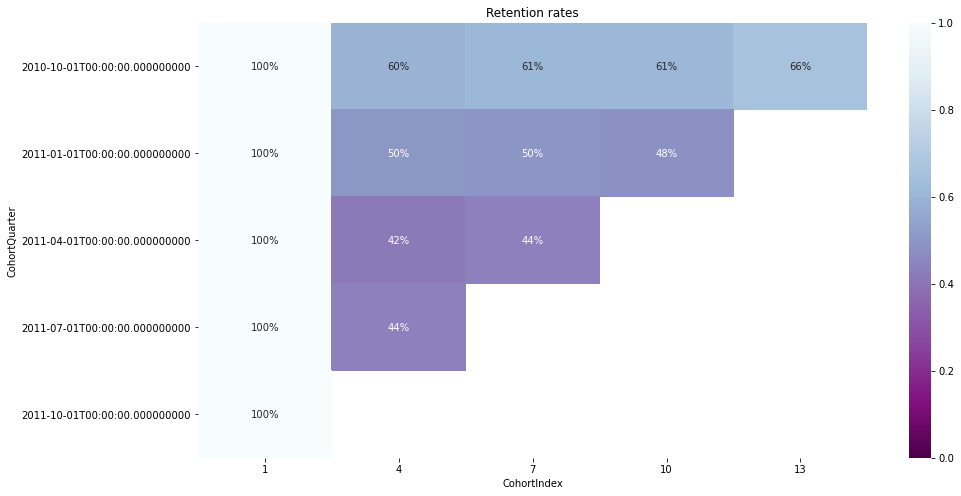

In [68]:
# Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data = quarter_table/100,annot = True,fmt = '.0%',vmin = 0.0,vmax = 1.0,cmap="BuPu_r")
plt.show()

In [71]:
month_table = generate_time_cohort_analysis(df, 'Month')
month_table

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


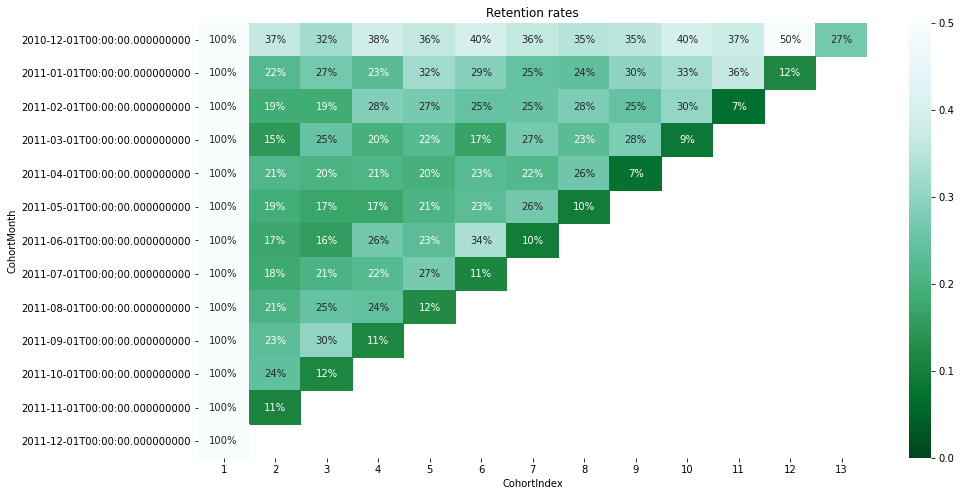

In [72]:
# Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=month_table/100,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuGn_r")
plt.show()

## Reference

[Customer Segmentation (RFM & Cohort Analysis)](https://www.kaggle.com/fszlnwr/customer-segmentation-rfm-cohort-analysis)

[Cohort Analysis & Customer Segmentation with RFM](https://www.kaggle.com/mahmoudelfahl/cohort-analysis-customer-segmentation-with-rfm)